# Survival Analysis - Handing of Non-Detects

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy import stats
from scipy.stats import lognorm
from fitter import Fitter
from scipy.optimize import minimize

## Import PFAS Database

In [2]:
def read_excel_sheet(excel_file, sheet_name):
    """
    Read a specific sheet from an Excel file into a DataFrame.

    Args:
        excel_file (str): The path to the Excel file.
        sheet_name (str): The name of the sheet to read.

    Returns:
        pd.DataFrame or None: A DataFrame containing the sheet data or None if the sheet is not found.
    """
    try:
        # Load the specified sheet from the Excel file into a DataFrame
        df = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=1)
        return df
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


In [3]:
# Example usage:

#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Database as of 12-12-2024.xlsm'
#Specify sheet name
sheet_name = 'PFAS Database'

#Call data import function
data_df = read_excel_sheet(excel_file_path, sheet_name)

data_df.head()

,Sampling point Date Component,Sample Number,Sampling Point,Sample Name,Sampled Date,Analysis,Component,Qualifiers,Result,Units,...,ChainLength,Pseudonym,Dominant Contributor,Sector,Depth,Edit Notes,Field,Notes,Region,Crop
0,ANODIZE SOLUTIONS (FPT)-43692.3333333333-10:2F...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,10:2Fluorotelomersulfonic Acid (Report),NaN,<9.40,ppt_wt_v,...,12.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN
1,ANODIZE SOLUTIONS (FPT)-43692.3333333333-11Cl-...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,11Cl-PF3OUdS (Report),NaN,<4.70,ppt_wt_v,...,10.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN
2,ANODIZE SOLUTIONS (FPT)-43692.3333333333-4:2Fl...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,4:2Fluorotelomersulfonic Acid (Report),NaN,<4.70,ppt_wt_v,...,6.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN
3,ANODIZE SOLUTIONS (FPT)-43692.3333333333-6:2Fl...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,6:2Fluorotelomersulfonic Acid (Report),NaN,<19.0,ppt_wt_v,...,8.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN
4,ANODIZE SOLUTIONS (FPT)-43692.3333333333-8:2Fl...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,8:2Fluorotelomersulfonic Acid (Report),NaN,<9.40,ppt_wt_v,...,10.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN


### Prep Data

In [141]:
# Define the list of acceptable values
acceptable_values = ['Good', 'Probably Ok', 'Probably ok', 'probably ok']

# Filter the DataFrame
filtered_df = data_df[data_df['Qual Summary (Grade for filtering)'].isin(acceptable_values)]

In [253]:
#Case 1
# Define the sample location you are interested in
sample_location = "Durham Effluent"
compound = 'Perfluorobutanoic acid'

#Case 2
sample_location = "Durham Influent"
compound = 'Perfluoroheptanoic acid'

#Case 3
#sample_location = "Durham Influent"
#compound = 'Perfluorohexanoic acid'

In [254]:
# Filter the DataFrame for the specified sample location
location_data = filtered_df[filtered_df['Sample Location'] == sample_location]

# Filter the DataFrame for the specified compound
location_compound_data = location_data[location_data['PFAS Compound'] == compound]

detected_mask = location_compound_data['Detection Class'] != 'BDL'

# Extract the series of values from the 'Quant Only Incl Qual Flags' column
quant_values_series = location_compound_data['Quant Only Incl Qual Flags']
quantEst_values_series = location_compound_data['Quant Incl Estimates Incl Qual Flags']
quant_HalfMDL_values_series = location_compound_data['All (w BDL= MDL/2) Incl Qual Flags']

# Separate detected and non-detected values
detected_values = quantEst_values_series[detected_mask]
non_detected_values = quantEst_values_series[~detected_mask]

### Explore Data

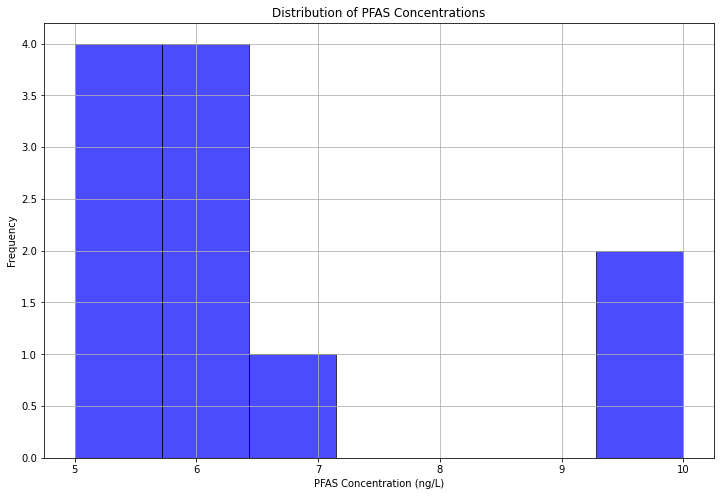

In [217]:
# Plotting the distribution of the PFAS concentrations
plt.figure(figsize=(12, 8))
# Create a histogram
#plt.hist(detected_values, bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.hist(detected_values, bins=7, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of PFAS Concentrations')
plt.xlabel('PFAS Concentration (ng/L)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.204616,33.797469,35.492317,inf,0.205461,0.573455
gamma,0.208797,34.448693,36.143542,inf,0.248020,0.342605
expon,0.212239,30.991572,32.121471,inf,0.209559,0.548752
exponpow,0.224761,33.544890,35.239738,inf,0.193014,0.650063
cauchy,0.228788,38.681341,39.811240,inf,0.254175,0.314770


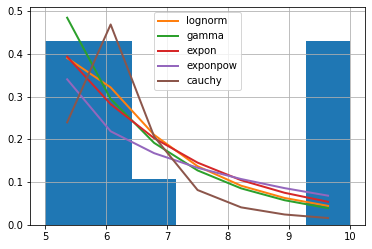

In [218]:
data = detected_values
data=quantEst_values_series
data=quant_HalfMDL_values_series

# Fitting multiple distributions to find the best fit
f = Fitter(data,bins=7, distributions=['norm', 'lognorm', 'expon', 'gamma', 'beta','cauchy', 'chi2','exponpow','powerlaw','rayleigh','uniform'])
f.fit()
f.summary()


In [219]:
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 0.9047071024886405,
  'loc': 4.742453733688747,
  'scale': 1.6680365108064432}}

## Estimating Central Tendencies (Mean and Standard Deviation)

### Quant and Estimates (BDL=0)

In [220]:
mean=quantEst_values_series.mean()
std=quantEst_values_series.std()
median=quantEst_values_series.median()
print('Mean =',mean)
print('Median =',median)
print('Std =',std)


Mean = 5.615384615384615
Median = 6.0
Std = 2.9506626808922527


In [186]:
quantEst_values_series

500       8.1
1044      7.7
1760      8.4
2804     13.0
3272     10.0
4532      9.8
4928      0.0
7124      4.6
10979     8.5
14014     5.7
15981     0.0
21905     0.0
23691     7.1
23729     1.8
27867     5.8
Name: Quant Incl Estimates Incl Qual Flags, dtype: float64

### Quant and Estimates (No 0s)

In [187]:
mean=quantEst_values_series[quantEst_values_series>0].mean()
std=quantEst_values_series[quantEst_values_series>0].std()
median=quantEst_values_series[quantEst_values_series>0].median()
print('Mean =',mean)
print('Median =',median)
print('Std =',std)

Mean = 7.541666666666665
Median = 7.9
Std = 2.878907094820196


In [188]:
quantEst_values_series[quantEst_values_series>0]

500       8.1
1044      7.7
1760      8.4
2804     13.0
3272     10.0
4532      9.8
7124      4.6
10979     8.5
14014     5.7
23691     7.1
23729     1.8
27867     5.8
Name: Quant Incl Estimates Incl Qual Flags, dtype: float64

### Quants only (Nondetects = 0)

In [189]:
mean=quant_values_series.mean()
std=quant_values_series.std()
median=quantEst_values_series.median()
print('Mean =',mean)
print('Median =',median)
print('Std =',std)

Mean = 1.2866666666666666
Median = 7.1
Std = 2.4439039806560867


In [190]:
quant_values_series

500      0.0
1044     0.0
1760     0.0
2804     0.0
3272     0.0
4532     0.0
4928     0.0
7124     4.6
10979    0.0
14014    0.0
15981    0.0
21905    0.0
23691    7.1
23729    1.8
27867    5.8
Name: Quant Only Incl Qual Flags, dtype: float64

### Quants and Non-Detects = 1/2 MDL

In [191]:
mean=quant_HalfMDL_values_series.mean()
std=quant_HalfMDL_values_series.std()
median=quantEst_values_series.median()
print('Mean =',mean)
print('Median =',median)
print('Std =',std)

Mean = 6.83
Median = 7.1
Std = 2.9905685078258952


In [192]:
quant_HalfMDL_values_series

500       8.10
1044      7.70
1760      8.40
2804     13.00
3272     10.00
4532      9.80
4928      2.45
7124      4.60
10979     8.50
14014     5.70
15981     4.50
21905     5.00
23691     7.10
23729     1.80
27867     5.80
Name: All (w BDL= MDL/2) Incl Qual Flags, dtype: float64

### Quant and Est, Non detects = MDL

In [193]:
data = quantEst_values_series.copy()
censored =~detected_mask
data[censored] = location_compound_data['MDL'][censored]
data

500       8.1
1044      7.7
1760      8.4
2804     13.0
3272     10.0
4532      9.8
4928      4.9
7124      4.6
10979     8.5
14014     5.7
15981     9.0
21905    10.0
23691     7.1
23729     1.8
27867     5.8
Name: Quant Incl Estimates Incl Qual Flags, dtype: float64

In [194]:
mean=data.mean()
std=data.std()
median=data.median()
print('Mean =',mean)
print('Median =',median)
print('Std =',std)

Mean = 7.626666666666666
Median = 8.1
Std = 2.7543385689455375


### Quant and Estimates and Imputing Non-Detects using Regression on Order Statistics (ROS)

#### Log-Normal distribution

In [195]:
# Fit a log-normal distribution to detects (log-transform detects to fit normal)
log_detects = np.log(detected_values)
mu, sigma = norm.fit(log_detects)

# Impute non-detects using ROS
ranks = non_detected_values.rank(pct=True)  # Get percentile ranks of non-detects
imputed_values = np.exp(norm.ppf(ranks, loc=mu, scale=sigma))  # Convert percentiles to values

# Replace non-detected values in the original series with imputed values
values=quantEst_values_series.copy()
values.loc[non_detected_values.index] = imputed_values

# Now you can compute statistics on the fully imputed dataset
mean_concentration = values.mean()
std_concentration = values.std()
median_concentration=values.median()

print("Mean Concentration:", mean_concentration)
print("Median Concentration:", median_concentration)
print("Standard Deviation:", std_concentration)

Mean Concentration: 7.725989318850858
Median Concentration: 8.4
Standard Deviation: 2.5802499473771854


In [196]:
values

500       8.10000
1044      7.70000
1760      8.40000
2804     13.00000
3272     10.00000
4532      9.80000
4928      8.46328
7124      4.60000
10979     8.50000
14014     5.70000
15981     8.46328
21905     8.46328
23691     7.10000
23729     1.80000
27867     5.80000
Name: Quant Incl Estimates Incl Qual Flags, dtype: float64

#### Normal Distribution

In [197]:
# Fit a normal distribution to detected values
mu, sigma = norm.fit(detected_values)

# Impute non-detects using ROS
ranks = non_detected_values.rank(pct=True, method='min')  # Adjust ranking method if necessary
imputed_values = norm.ppf(ranks, loc=mu, scale=sigma)  # Convert percentiles to values

# Replace non-detected values in the original series with imputed values
values=quantEst_values_series.copy()
values.loc[non_detected_values.index] = imputed_values

# Now you can compute statistics on the imputed dataset
mean_concentration = values.mean()
std_concentration = values.std()
median_concentration=values.median()

print("Mean Concentration:", mean_concentration)
print("Median Concentration:", median_concentration)
print("Standard Deviation:", std_concentration)

Mean Concentration: 7.304220171678242
Median Concentration: 7.1
Standard Deviation: 2.598791160542641


In [198]:
values

500       8.100000
1044      7.700000
1760      8.400000
2804     13.000000
3272     10.000000
4532      9.800000
4928      6.354434
7124      4.600000
10979     8.500000
14014     5.700000
15981     6.354434
21905     6.354434
23691     7.100000
23729     1.800000
27867     5.800000
Name: Quant Incl Estimates Incl Qual Flags, dtype: float64

Assumes a normal distribution.  Since the normal distribution is not bounded, the imputation might result in negative values

#### Cumulative distribution function

In [199]:
# Calculate the ECDF for detected values
ecdf = stats.rankdata(detected_values, method='average') / len(detected_values)

# Assign non-detects a value based on their rank percentile
# Ranks for non-detects
non_detected_ranks = non_detected_values.rank(pct=True, method='average')
# Use linear interpolation to assign values based on the ECDF
imputed_values = np.interp(non_detected_ranks, np.linspace(0, 1, len(detected_values)), np.sort(detected_values))

# Replace non-detected values in the original series with imputed values
values=quantEst_values_series.copy()
values.loc[non_detected_values.index] = imputed_values

# Now you can compute statistics on the fully imputed dataset
mean_concentration = quantEst_values_series.mean()
std_concentration = quantEst_values_series.std()
median_concentration=values.median()

print("Mean Concentration:", mean_concentration)
print("Median Concentration:", median_concentration)
print("Standard Deviation:", std_concentration)

Mean Concentration: 6.033333333333332
Median Concentration: 8.4
Standard Deviation: 4.032664249894969


In [200]:
values

500       8.100000
1044      7.700000
1760      8.400000
2804     13.000000
3272     10.000000
4532      9.800000
4928      8.433333
7124      4.600000
10979     8.500000
14014     5.700000
15981     8.433333
21905     8.433333
23691     7.100000
23729     1.800000
27867     5.800000
Name: Quant Incl Estimates Incl Qual Flags, dtype: float64

Non-Parametric: This method is suitable for data without a clear distributional assumption.

#### ROS with Exponential Distribution

In [201]:
from scipy.stats import expon
# Fit a normal distribution to detected values
mu, sigma = norm.fit(detected_values)

# Impute non-detects using ROS
ranks = non_detected_values.rank(pct=True, method='min')  # Adjust ranking method if necessary
imputed_values = expon.ppf(ranks, loc=mu, scale=sigma)  # Convert percentiles to values

# Replace non-detected values in the original series with imputed values
values=quantEst_values_series.copy()
values.loc[non_detected_values.index] = imputed_values

# Now you can compute statistics on the imputed dataset
mean_concentration = values.mean()
std_concentration = values.std()
median_concentration=values.median()

print("Mean Concentration:", mean_concentration)
print("Median Concentration:", median_concentration)
print("Standard Deviation:", std_concentration)

Mean Concentration: 7.765186905383518
Median Concentration: 8.4
Standard Deviation: 2.5934924673336446


In [202]:
values

500       8.100000
1044      7.700000
1760      8.400000
2804     13.000000
3272     10.000000
4532      9.800000
4928      8.659268
7124      4.600000
10979     8.500000
14014     5.700000
15981     8.659268
21905     8.659268
23691     7.100000
23729     1.800000
27867     5.800000
Name: Quant Incl Estimates Incl Qual Flags, dtype: float64

### Maximum Likelihood Estimation

#### Log-normal, 0 are omitted

In [203]:
# We filter out the zeros for the MLE as they represent non-detects which are treated as censored below the detection limit
data_filtered = quantEst_values_series[quantEst_values_series > 0]

# Log-transform the data
log_data = np.log(data_filtered)

# Use MLE to estimate the parameters of the log-normal distribution
shape, loc, scale = lognorm.fit(data_filtered, floc=0)  # Forcing location parameter to zero for a standard log-normal

# Estimated parameters
mu = np.log(scale)  # Mean of log-transformed data
sigma = shape  # Standard deviation of log-transformed data

# Calculate the mean of the original log-normal distribution
original_mean = np.exp(mu + (sigma**2 / 2))

# Calculate the standard deviation of the original log-normal distribution
original_std = np.sqrt((np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2))

# Calculate median of the original log-normal distribution
original_median = np.exp(mu)

print("Mean of original data:", original_mean)
print("Median of original data:", original_median)
print("Standard deviation of original data:", original_std)

Mean of original data: 7.72475651082471
Median of original data: 6.86862136715563
Standard deviation of original data: 3.9752486524787214


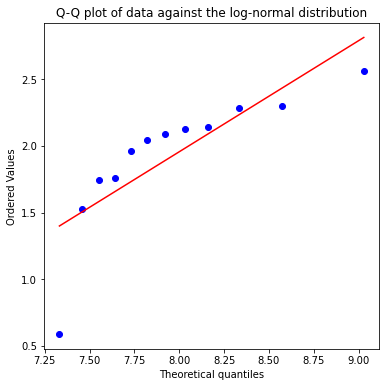

In [204]:
# Assuming `log_data` is your log-transformed data
data_filtered = quantEst_values_series[quantEst_values_series > 0]
log_data = np.log(data_filtered)

# Generate a Q-Q plot
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(log_data, dist="lognorm", sparams=(shape, scale), plot=ax)
ax.set_title('Q-Q plot of data against the log-normal distribution')
plt.show()

In [205]:
# Compute the K-S test
D, p_value = stats.kstest(log_data, 'lognorm', args=(shape, 0, scale))

print(f"K-S statistic: {D}")
print(f"p-value: {p_value}")
#Note: A high p-value (typically >0.05) suggests that your data do not significantly differ from the log-normal distribution.

K-S statistic: 0.9789351707030193
p-value: 1.5266002342725838e-20


#### Log-normal 1/2 MDL

In [206]:
# Log-transform the data
log_data = np.log(quant_HalfMDL_values_series)

# Use MLE to estimate the parameters of the log-normal distribution
shape, loc, scale = lognorm.fit(quant_HalfMDL_values_series, floc=0)  # Forcing location parameter to zero for a standard log-normal

# Estimated parameters
mu = np.log(scale)  # Mean of log-transformed data
sigma = shape  # Standard deviation of log-transformed data

# Calculate the mean of the original log-normal distribution
original_mean = np.exp(mu + (sigma**2 / 2))

# Calculate the standard deviation of the original log-normal distribution
original_std = np.sqrt((np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2))

# Calculate median of the original log-normal distribution
original_median = np.exp(mu)

print("Mean of original data:", original_mean)
print("Median of original data:", original_median)
print("Standard deviation of original data:", original_std)

Mean of original data: 6.963096721729985
Median of original data: 6.103593025252765
Standard deviation of original data: 3.8231692447979255


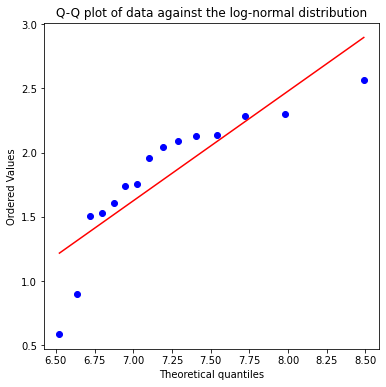

In [207]:
# Generate a Q-Q plot
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(log_data, dist="lognorm", sparams=(shape, scale), plot=ax)
ax.set_title('Q-Q plot of data against the log-normal distribution')
plt.show()

In [208]:
# Compute the K-S test
D, p_value = stats.kstest(log_data, 'lognorm', args=(shape, 0, scale))

print(f"K-S statistic: {D}")
print(f"p-value: {p_value}")
#Note: A high p-value (typically >0.05) suggests that your data do not significantly differ from the log-normal distribution.

K-S statistic: 0.9543805886610206
p-value: 1.5426775163391053e-20


#### MLE, exponential, 1/2 MDL

In [209]:
# Impute non-detects with half the MDL
quant_HalfMDL_values_series = quantEst_values_series.copy()
non_detected_mask = ~detected_mask
quant_HalfMDL_values_series[non_detected_mask] = location_compound_data['MDL'][non_detected_mask] / 2

# Fit an exponential distribution to the imputed data
loc, scale = expon.fit(quant_HalfMDL_values_series, floc=0)  # Assuming the location parameter is zero

# Calculate the mean, standard deviation, and median from the exponential distribution
mean_exponential = scale  # Mean of the exponential distribution is the scale parameter
std_exponential = scale   # Standard deviation of the exponential distribution is also the scale parameter
median_exponential = np.log(2) * scale  # Median of the exponential distribution

print("Mean of imputed data:", mean_exponential)
print("Median of imputed data:", median_exponential)
print("Standard deviation of imputed data:", std_exponential)


Mean of imputed data: 6.83
Median of imputed data: 4.734195243224426
Standard deviation of imputed data: 6.83


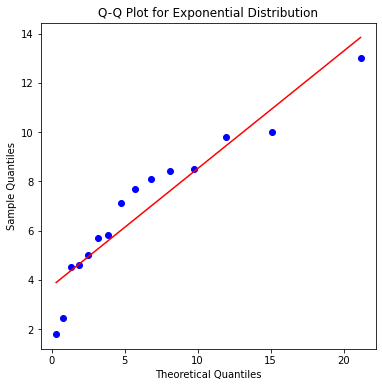

In [210]:
# Generate Q-Q plot for the exponential distribution
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(quant_HalfMDL_values_series, dist="expon", sparams=(loc, scale), plot=ax)
ax.set_title('Q-Q Plot for Exponential Distribution')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')

plt.show()

In [211]:
# Compute the K-S test
D, p_value = stats.kstest(quant_HalfMDL_values_series, 'expon', args=(shape, scale))

print(f"K-S statistic: {D}")
print(f"p-value: {p_value}")
#Note: A high p-value (typically >0.05) suggests that your data do not significantly differ from the log-normal distribution.

K-S statistic: 0.30883715318777094
p-value: 0.0908918342542866


#### MLE, normal, 1/2 MDL

In [212]:
from scipy.stats import norm
import numpy as np

# Impute non-detects with half the MDL
quant_HalfMDL_values_series = quantEst_values_series.copy()
non_detected_mask = ~detected_mask
quant_HalfMDL_values_series[non_detected_mask] = location_compound_data['MDL'][non_detected_mask] / 2

# Fit a normal distribution to the imputed data
mean_normal, std_normal = norm.fit(quant_HalfMDL_values_series)

# Calculate mean, standard deviation, and median from the normal distribution
mean_imputed = mean_normal
std_imputed = std_normal
median_imputed = mean_normal  # Median of a normal distribution is its mean

print("Mean of imputed data:", mean_imputed)
print("Median of imputed data:", median_imputed)
print("Standard deviation of imputed data:", std_imputed)


Mean of imputed data: 6.83
Median of imputed data: 6.83
Standard deviation of imputed data: 2.889163662146308


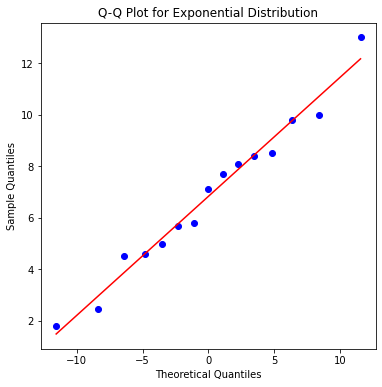

In [213]:
# Generate Q-Q plot for the exponential distribution
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(quant_HalfMDL_values_series, dist="norm", sparams=(loc, scale), plot=ax)
ax.set_title('Q-Q Plot for Exponential Distribution')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')

plt.show()

In [214]:
# Compute the K-S test
D, p_value = stats.kstest(quant_HalfMDL_values_series, 'expon', args=(shape, scale))

print(f"K-S statistic: {D}")
print(f"p-value: {p_value}")
#Note: A high p-value (typically >0.05) suggests that your data do not significantly differ from the log-normal distribution.

K-S statistic: 0.30883715318777094
p-value: 0.0908918342542866


#### MLE, Non-Detects as Censored data, normal

In [255]:
# Observed data
detected_values = quantEst_values_series[detected_mask]
non_detect_values = location_compound_data['MDL'][~detected_mask]

# Define the negative log-likelihood function for censored data
def neg_log_likelihood(params):
    mu, sigma = params
    if sigma <= 0:  # Standard deviation must be positive
        return np.inf
    
    # Likelihood for detected values (PDF of normal distribution)
    log_likelihood_detected = np.sum(norm.logpdf(detected_values, loc=mu, scale=sigma))
    
    # Likelihood for censored values (CDF of normal distribution)
    log_likelihood_non_detect = np.sum(np.log(norm.cdf(non_detect_values, loc=mu, scale=sigma)))
    
    # Total negative log-likelihood
    return -(log_likelihood_detected + log_likelihood_non_detect)

# Initial guesses for mu and sigma
initial_guess = [np.mean(detected_values), np.std(detected_values)]

# Optimize the negative log-likelihood
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=[(None, None), (1e-6, None)])

# Extract fitted parameters
mu_mle, sigma_mle = result.x

# Print the results
print("Fitted Mean (μ):", mu_mle)
print("Fitted Standard Deviation (σ):", sigma_mle)

# Optional: Calculate other statistics
median_mle = mu_mle  # Median for a normal distribution
print("Median (MLE):", median_mle)


Fitted Mean (μ): 2.5280277262394946
Fitted Standard Deviation (σ): 1.1643531482448006
Median (MLE): 2.5280277262394946


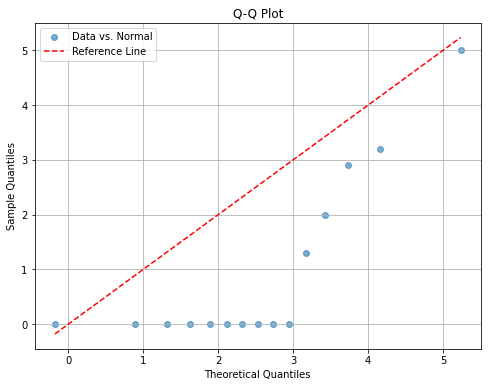

K-S Statistic: 0.6517081243711935
P-Value: 9.301715592178423e-07
The data does not fit the normal distribution (reject H0).


In [256]:
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest

# Q-Q Plot
def plot_qq(data, mu, sigma):
    sorted_data = np.sort(data)
    theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(sorted_data)), loc=mu, scale=sigma)
    plt.figure(figsize=(8, 6))
    plt.scatter(theoretical_quantiles, sorted_data, label="Data vs. Normal", alpha=0.6)
    plt.plot(theoretical_quantiles, theoretical_quantiles, color='red', linestyle='--', label="Reference Line")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.title("Q-Q Plot")
    plt.legend()
    plt.grid()
    plt.show()

# Perform K-S Test
def perform_ks_test(data, mu, sigma):
    ks_stat, p_value = kstest(data, 'norm', args=(mu, sigma))
    print(f"K-S Statistic: {ks_stat}")
    print(f"P-Value: {p_value}")
    if p_value > 0.05:
        print("The data fits the normal distribution (fail to reject H0).")
    else:
        print("The data does not fit the normal distribution (reject H0).")

# Call the functions
plot_qq(quantEst_values_series, mu_mle, sigma_mle)  # Adjust input data as needed
perform_ks_test(quantEst_values_series, mu_mle, sigma_mle)


#### MLE, Censored, log normal distribution

In [257]:
from scipy.stats import lognorm
from scipy.optimize import minimize
import numpy as np

# Observed data
detected_values = quantEst_values_series[detected_mask]
non_detect_values = location_compound_data['MDL'][~detected_mask]

# Define the negative log-likelihood function for censored data
def neg_log_likelihood(params):
    mu, sigma = params
    if sigma <= 0:  # Standard deviation must be positive
        return np.inf
    
    # Likelihood for detected values (PDF of log-normal distribution)
    log_likelihood_detected = np.sum(lognorm.logpdf(detected_values, s=sigma, scale=np.exp(mu)))
    
    # Likelihood for censored values (CDF of log-normal distribution)
    log_likelihood_non_detect = np.sum(np.log(lognorm.cdf(non_detect_values, s=sigma, scale=np.exp(mu))))
    
    # Total negative log-likelihood
    return -(log_likelihood_detected + log_likelihood_non_detect)

# Initial guesses for mu and sigma
log_detected_values = np.log(detected_values)
initial_guess = [np.mean(log_detected_values), np.std(log_detected_values)]

# Optimize the negative log-likelihood
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=[(None, None), (1e-6, None)])

# Extract fitted parameters
mu_mle, sigma_mle = result.x

# Convert parameters to the original scale
median_mle = np.exp(mu_mle)  # Median for a log-normal distribution is exp(mu)
mean_mle = np.exp(mu_mle + (sigma_mle**2) / 2)  # Mean for a log-normal distribution
std_mle = np.sqrt((np.exp(sigma_mle**2) - 1) * np.exp(2 * mu_mle + sigma_mle**2))  # Standard deviation

# Print the results
print("Fitted Parameters for Log-Normal Distribution:")
print("Mean (Original Scale):", mean_mle)
print("Median (Original Scale):", median_mle)
print("Standard Deviation (Original Scale):", std_mle)


Fitted Parameters for Log-Normal Distribution:
Mean (Original Scale): 2.5133186647154964
Median (Original Scale): 2.313360400942728
Standard Deviation (Original Scale): 1.0673286056183031


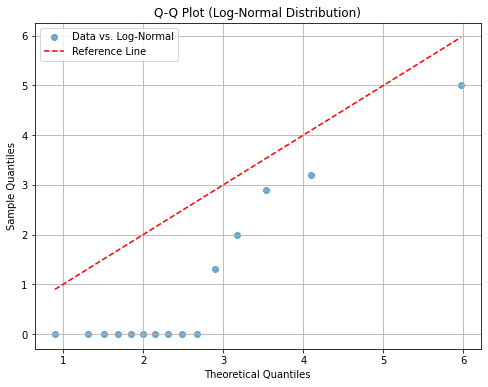

K-S Statistic: 0.6666666666666666
P-Value: 4.295946720937011e-07
The data does not fit the log-normal distribution (reject H0).


In [258]:
import matplotlib.pyplot as plt
from scipy.stats import kstest

# Q-Q Plot for Log-Normal Distribution
def plot_qq_lognormal(data, mu, sigma):
    sorted_data = np.sort(data)
    theoretical_quantiles = lognorm.ppf(np.linspace(0.01, 0.99, len(sorted_data)), s=sigma, scale=np.exp(mu))
    plt.figure(figsize=(8, 6))
    plt.scatter(theoretical_quantiles, sorted_data, label="Data vs. Log-Normal", alpha=0.6)
    plt.plot(theoretical_quantiles, theoretical_quantiles, color='red', linestyle='--', label="Reference Line")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.title("Q-Q Plot (Log-Normal Distribution)")
    plt.legend()
    plt.grid()
    plt.show()

# Perform K-S Test for Log-Normal Distribution
def perform_ks_test_lognormal(data, mu, sigma):
    ks_stat, p_value = kstest(data, 'lognorm', args=(sigma, 0, np.exp(mu)))
    print(f"K-S Statistic: {ks_stat}")
    print(f"P-Value: {p_value}")
    if p_value > 0.05:
        print("The data fits the log-normal distribution (fail to reject H0).")
    else:
        print("The data does not fit the log-normal distribution (reject H0).")

# Call the functions
plot_qq_lognormal(quantEst_values_series, mu_mle, sigma_mle)
perform_ks_test_lognormal(quantEst_values_series, mu_mle, sigma_mle)


### Kaplan-Meier

#### Case 1

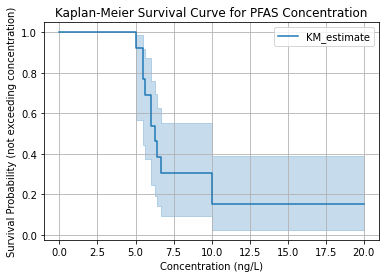

Estimated Median Concentration: 6.3
Summary Statistics of Survival Function:
        KM_estimate
count    10.000000
mean      0.538462
std       0.301214
min       0.153846
25%       0.326923
50%       0.500000
75%       0.750000
max       1.000000


In [35]:
from lifelines import KaplanMeierFitter
#Case 1
data = quantEst_values_series.copy()
censored =~detected_mask

detection_limit = 20
data[censored] = detection_limit

# Create Kaplan-Meier object
kmf = KaplanMeierFitter()
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Assuming `data` is your series of PFAS concentrations
# `censored` is a boolean series where True indicates the data point is censored (non-detect)

# Create Kaplan-Meier object
kmf = KaplanMeierFitter()

# Fit KM model
# The `event_observed` parameter is True if the event (detection above MDL) is observed; hence, `~censored`
kmf.fit(durations=data, event_observed=~censored)

# Plot the survival function
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve for PFAS Concentration')
plt.xlabel('Concentration (ng/L)')
plt.ylabel('Survival Probability (not exceeding concentration)')
plt.grid(True)
plt.show()


# Fit KM model
kmf.fit(data, ~censored)  # `~censored` because lifelines treats True as "event occurred"

# Estimate the mean and variance from the survival function
# Lifelines doesn't directly give mean/variance for KM, but we can approximate or use their utility functions
mean_survival_time = kmf.median_survival_time_
summary_stats = kmf.survival_function_.describe()

print("Estimated Median Concentration:", mean_survival_time)
print("Summary Statistics of Survival Function:\n", summary_stats)

In [36]:
# Function to perform bootstrap and estimate the mean survival time
def bootstrap_mean_survival_time(data, censored, iterations=1000):
    n = len(data)
    means = []
    
    for _ in range(iterations):
        # Sample with replacement
        indices = np.random.choice(n, n, replace=True)
        sample = data.iloc[indices]
        sample_censored = censored.iloc[indices]
        
        # Fit KM model
        kmf = KaplanMeierFitter()
        kmf.fit(sample, event_observed=~sample_censored)
        
        # Extract the survival function
        survival_function = kmf.survival_function_
        
        # Estimate mean survival time - approximate by summing the survival probabilities
        mean_time = (survival_function.index * survival_function['KM_estimate']).sum()
        means.append(mean_time)
    
    return np.mean(means), np.std(means)

# Call the bootstrap function
mean_estimate, std_estimate = bootstrap_mean_survival_time(data, censored)
print("Bootstrap Mean Survival Time:", mean_estimate)
print("Standard Deviation of Bootstrap Estimates:", std_estimate)


Bootstrap Mean Survival Time: 20.62803076923077
Standard Deviation of Bootstrap Estimates: 4.835769822782606


#### Case 2

In [84]:
from lifelines import KaplanMeierFitter

data = quantEst_values_series.copy()
censored =~detected_mask
data[censored] = location_compound_data['MDL'][censored]

# Create Kaplan-Meier object
kmf = KaplanMeierFitter()

# Fit KM model
kmf.fit(data, ~censored)  # `~censored` because lifelines treats True as "event occurred"

# Estimate the mean and variance from the survival function
# Lifelines doesn't directly give mean/variance for KM, but we can approximate or use their utility functions
mean_survival_time = kmf.median_survival_time_
summary_stats = kmf.survival_function_.describe()

print("Estimated Median Concentration:", mean_survival_time)
print("Summary Statistics of Survival Function:\n", summary_stats)

Estimated Median Concentration: inf
Summary Statistics of Survival Function:
        KM_estimate
count     9.000000
mean      0.788889
std       0.135974
min       0.540000
25%       0.720000
50%       0.800000
75%       0.866667
max       1.000000


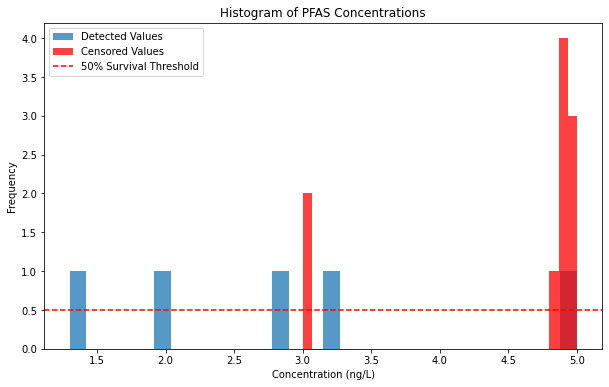

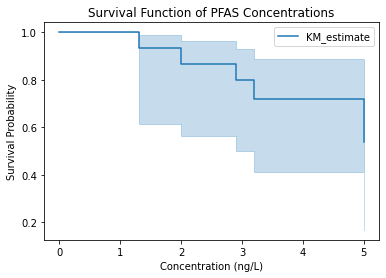

In [85]:
import matplotlib.pyplot as plt

# Plot histogram of detected values and mark the detection limits
plt.figure(figsize=(10, 6))
plt.hist(data[~censored], bins=30, alpha=0.75, label='Detected Values')
plt.hist(data[censored], bins=30, alpha=0.75, color='red', label='Censored Values')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% Survival Threshold')
plt.xlabel('Concentration (ng/L)')
plt.ylabel('Frequency')
plt.title('Histogram of PFAS Concentrations')
plt.legend()
plt.show()

# Plot the Kaplan-Meier survival curve
kmf.plot_survival_function()
plt.title('Survival Function of PFAS Concentrations')
plt.xlabel('Concentration (ng/L)')
plt.ylabel('Survival Probability')
plt.show()


#### Case 3

In [136]:
from lifelines import KaplanMeierFitter

data = quantEst_values_series.copy()
censored =~detected_mask
data[censored] = location_compound_data['MDL'][censored]

# Create Kaplan-Meier object
kmf = KaplanMeierFitter()

# Fit KM model
kmf.fit(data, ~censored)  # `~censored` because lifelines treats True as "event occurred"

# Estimate the mean and variance from the survival function
# Lifelines doesn't directly give mean/variance for KM, but we can approximate or use their utility functions
mean_survival_time = kmf.median_survival_time_
summary_stats = kmf.survival_function_.describe()

print("Estimated Median Concentration:", mean_survival_time)
print("Summary Statistics of Survival Function:\n", summary_stats)

Estimated Median Concentration: 8.4
Summary Statistics of Survival Function:
        KM_estimate
count    15.000000
mean      0.568241
std       0.298695
min       0.000000
25%       0.361111
50%       0.577778
75%       0.830556
max       1.000000


In [139]:
quantEst_values_series


500       8.1
1044      7.7
1760      8.4
2804     13.0
3272     10.0
4532      9.8
4928      0.0
7124      4.6
10979     8.5
14014     5.7
15981     0.0
21905     0.0
23691     7.1
23729     1.8
27867     5.8
Name: Quant Incl Estimates Incl Qual Flags, dtype: float64

In [140]:
location_compound_data['MDL'][censored]

4928      4.9
15981     9.0
21905    10.0
Name: MDL, dtype: float64

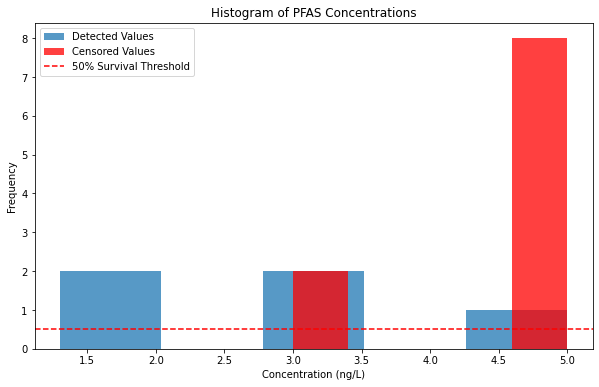

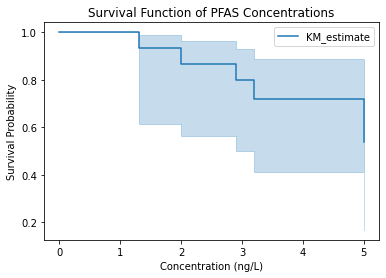

In [87]:
import matplotlib.pyplot as plt

# Plot histogram of detected values and mark the detection limits
plt.figure(figsize=(10, 6))
plt.hist(data[~censored], bins=5, alpha=0.75, label='Detected Values')
plt.hist(data[censored], bins=5, alpha=0.75, color='red', label='Censored Values')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% Survival Threshold')
plt.xlabel('Concentration (ng/L)')
plt.ylabel('Frequency')
plt.title('Histogram of PFAS Concentrations')
plt.legend()
plt.show()

# Plot the Kaplan-Meier survival curve
kmf.plot_survival_function()
plt.title('Survival Function of PFAS Concentrations')
plt.xlabel('Concentration (ng/L)')
plt.ylabel('Survival Probability')
plt.show()


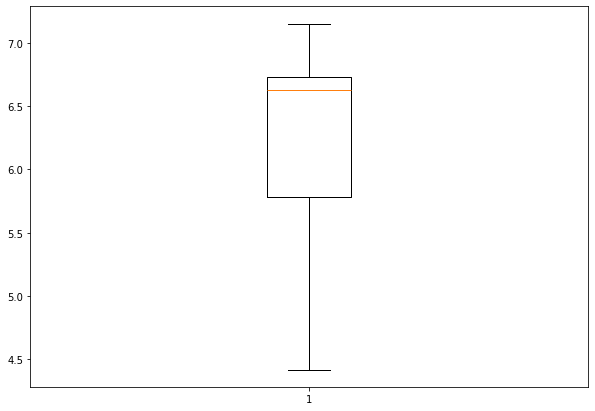

In [88]:
data = [5.61,6.63,4.42,7.15,6.76,6.63,5.61,6.62,7.14,6.3]

fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.boxplot(data)

# show plot
plt.show()